<a href="https://colab.research.google.com/github/Bhavesh2k4/cookbook/blob/Added-Text-Image-Multimodal-Bot-549/quickstarts/Gemini_Multimodal_Text_Image_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2024 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API: Multimodal Chatbot using Google Gemini API


<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/Bhavesh2k4/cookbook/blob/Added-Text-Image-Multimodal-Bot-549/quickstarts/Gemini_Multimodal_Text_Image_Tutorial.ipynb"><img src="https://github.com/Bhavesh2k4/cookbook/blob/Bhavesh2k4%2FAdded-GeminiAPI-Text-Image-Tutorial-549/images/colab_logo_32px.png?raw=1" />Run in Google Colab</a>
  </td>
</table>



## Overview
This notebook walks through the process of creating a multimodal chatbot using Google's Gemini API. The chatbot can:
- Process text inputs
- Analyze images
- Handle combined text and image inputs (multimodal prompts)
- Maintain conversation history for contextual responses
- Format and present responses with markdown support

## Prerequisites
- Google API key for Gemini
- Python 3.9+
- Required libraries: google-generativeai, pillow, IPython, pandas, matplotlib

In [ ]:
# Environment Setup
!pip install google-generativeai pillow IPython pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.7 MB/s eta 0:00:00


In [ ]:
# Import Libraries
import os
import time
import base64
from typing import List, Dict, Tuple, Optional, Union
from io import BytesIO
from IPython.display import display, Markdown, Image
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image as PILImage
import google.generativeai as genai

## Set up your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see the [Authentication](../quickstarts/Authentication.ipynb) quickstart for an example.

In [ ]:
from google.colab import userdata
GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

## Available Gemini Models

Function to List and Display all Gemini Models

In [ ]:
# Function to list available models
def list_available_models():
    """Display information about available Gemini models."""
    models = genai.list_models()
    model_info = []

    for model in models:
        if 'gemini' in model.name.lower():
            supported_features = []
            if hasattr(model, 'supported_generation_methods'):
                supported_features = model.supported_generation_methods

            model_info.append({
                'Name': model.name,
                'Description': model.description,
                'Input Types': model.input_token_limit if hasattr(model, 'input_token_limit') else 'Unknown',
                'Output Limit': model.output_token_limit if hasattr(model, 'output_token_limit') else 'Unknown',
                'Features': supported_features
            })

    return pd.DataFrame(model_info)

# Display available models
display(Markdown("### Available Gemini Models"))
models_df = list_available_models()
display(models_df)

### Available Gemini Models

,Name,Description,Input Types,Output Limit,Features
0,models/gemini-1.0-pro-vision-latest,The original Gemini 1.0 Pro Vision model versi...,12288,4096,"[generateContent, countTokens]"
1,models/gemini-pro-vision,The original Gemini 1.0 Pro Vision model versi...,12288,4096,"[generateContent, countTokens]"
2,models/gemini-1.5-pro-latest,Alias that points to the most recent productio...,2000000,8192,"[generateContent, countTokens]"
3,models/gemini-1.5-pro-001,"Stable version of Gemini 1.5 Pro, our mid-size...",2000000,8192,"[generateContent, countTokens, createCachedCon..."
4,models/gemini-1.5-pro-002,"Stable version of Gemini 1.5 Pro, our mid-size...",2000000,8192,"[generateContent, countTokens, createCachedCon..."
5,models/gemini-1.5-pro,"Stable version of Gemini 1.5 Pro, our mid-size...",2000000,8192,"[generateContent, countTokens]"
6,models/gemini-1.5-flash-latest,Alias that points to the most recent productio...,1000000,8192,"[generateContent, countTokens]"
7,models/gemini-1.5-flash-001,"Stable version of Gemini 1.5 Flash, our fast a...",1000000,8192,"[generateContent, countTokens, createCachedCon..."
8,models/gemini-1.5-flash-001-tuning,Version of Gemini 1.5 Flash that supports tuni...,16384,8192,"[generateContent, countTokens, createTunedModel]"
9,models/gemini-1.5-flash,Alias that points to the most recent stable ve...,1000000,8192,"[generateContent, countTokens]"


## Choose the Model

In [ ]:
#Choose the model
MODEL_NAME = "gemini-1.5-flash"

#For Better Performance - You can choose Gemini Pro (Make Note of Rate Limits)

## Image Processing Utilities
These functions help prepare and process images for the Gemini model.

In [ ]:
def load_image_from_path(image_path: str) -> PILImage.Image:
    """
    Load an image from a file path.

    Args:
        image_path: Path to the image file

    Returns:
        PIL Image object
    """
    try:
        image = PILImage.open(image_path)
        return image
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

def load_image_from_url(image_url: str) -> PILImage.Image:
    """
    Load an image from a URL.

    Args:
        image_url: URL of the image

    Returns:
        PIL Image object
    """
    try:
        import requests
        response = requests.get(image_url)
        image = PILImage.open(BytesIO(response.content))
        return image
    except Exception as e:
        print(f"Error loading image from URL: {e}")
        return None

def resize_image(image: PILImage.Image, max_size: int = 1024) -> PILImage.Image:
    """
    Resize an image while maintaining aspect ratio to ensure it's under
    the size limits for the API.

    Args:
        image: PIL Image object
        max_size: Maximum dimension (width or height)

    Returns:
        Resized PIL Image object
    """
    width, height = image.size

    if max(width, height) > max_size:
        if width > height:
            new_width = max_size
            new_height = int(height * max_size / width)
        else:
            new_height = max_size
            new_width = int(width * max_size / height)

        return image.resize((new_width, new_height))

    return image

def display_image(image: PILImage.Image, width: int = 400):
    """
    Display an image with specified width in the notebook.

    Args:
        image: PIL Image object
        width: Display width
    """
    buffer = BytesIO()
    image.save(buffer, format="PNG")
    image_data = buffer.getvalue()

    display(Image(data=image_data, width=width))

## ChatBot Class Definition
This class encapsulates our chatbot functionality, including handling text and image inputs,
maintaining conversation history, and processing responses.

In [ ]:
class GeminiMultimodalChatBot:
    """
    A chatbot that can process both text and images using Google's Gemini models.

    Attributes:
        model_name: Name of the Gemini model to use
        temperature: Controls randomness in responses (0.0 to 1.0)
        max_tokens: Maximum number of tokens in the response
        top_p: Controls diversity via nucleus sampling
        top_k: Controls diversity via top-k sampling
        conversation: The Gemini conversation object that maintains history
    """

    def __init__(
        self,
        model_name: str = MODEL_NAME,
        temperature: float = 0.7,
        max_tokens: int = 2048,
        top_p: float = 0.95,
        top_k: int = 40,
        system_prompt: str = None
    ):
        """
        Initialize the chatbot with configuration parameters.

        Args:
            model_name: Name of the Gemini model to use
            temperature: Controls randomness (higher = more random)
            max_tokens: Maximum output length
            top_p: Controls diversity via nucleus sampling
            top_k: Controls diversity via top-k sampling
            system_prompt: Initial instructions for the model
        """
        self.model_name = model_name
        self.temperature = temperature
        self.max_tokens = max_tokens
        self.top_p = top_p
        self.top_k = top_k

        # Initialize the model
        self.model = genai.GenerativeModel(
            model_name=self.model_name,
            generation_config={
                "temperature": self.temperature,
                "max_output_tokens": self.max_tokens,
                "top_p": self.top_p,
                "top_k": self.top_k
            }
        )

        # Start a new conversation
        self.reset_conversation(system_prompt)

    def reset_conversation(self, system_prompt: str = None):
        """
        Reset the conversation history.

        Args:
            system_prompt: Initial instructions for the model
        """
        if system_prompt:
            self.conversation = self.model.start_chat(history=[
                {"role": "user", "parts": ["I need you to follow these instructions: " + system_prompt]},
                {"role": "model", "parts": ["I'll follow these instructions throughout our conversation."]}
            ])
        else:
            self.conversation = self.model.start_chat(history=[])

    def send_message(self,
                    text: str = None,
                    image: PILImage.Image = None,
                    stream: bool = False) -> str:
        """
        Send a message to the chatbot with optional image.

        Args:
            text: Text prompt to send
            image: Optional image to include
            stream: Whether to stream the response

        Returns:
            Response from the model
        """
        # Create the content parts
        content_parts = []

        # Add text if provided
        if text:
            content_parts.append(text)

        # Add image if provided
        if image:
            content_parts.append(image)

        # Ensure you have at least one content part
        if not content_parts:
            raise ValueError("Must provide at least text or image")

        try:
            # Send the message to the model
            if stream:
                response = self.conversation.send_message(content_parts, stream=True)

                # Process streamed response
                full_response = ""
                for chunk in response:
                    if hasattr(chunk, 'text'):
                        print(chunk.text, end="", flush=True)
                        full_response += chunk.text
                print()  # New line after streaming completes
                return full_response
            else:
                response = self.conversation.send_message(content_parts)
                return response.text

        except Exception as e:
            error_msg = f"Error communicating with Gemini API: {str(e)}"
            print(error_msg)
            return error_msg

    def get_conversation_history(self):
        """
        Get the current conversation history.

        Returns:
            List of conversation turns
        """
        return self.conversation.history

    def display_conversation(self):
        """Display the conversation history in a readable format."""
        history = self.get_conversation_history()

        for entry in history:
            # Skip the system prompt exchange if desired
            if hasattr(entry, 'role'):
                role = entry.role

                if role == "user":
                    display(Markdown("### 👤 User:"))

                    for part in entry.parts:
                        if hasattr(part, 'text'):
                            display(Markdown(part.text))
                        elif hasattr(part, 'inline_data') and part.inline_data:
                            display(Markdown("*[Image input]*"))

                elif role == "model":
                    display(Markdown("### 🤖 Gemini:"))

                    for part in entry.parts:
                        if hasattr(part, 'text'):
                            display(Markdown(part.text))

## Initialize the ChatBot
Let's create our chatbot instance with some custom parameters.

In [ ]:
# Define a system prompt to guide the model's behavior
system_prompt = """
You are a helpful, friendly assistant. When responding to questions:
- If you're unsure, be honest about your limitations
- Provide detailed and accurate information
- For image analysis, describe what you see in detail
- Use markdown formatting to make responses easy to read
- When discussing code, include well-commented examples
"""

# Initialize the chatbot
chatbot = GeminiMultimodalChatBot(
    temperature=0.7,
    max_tokens=4096,
    system_prompt=system_prompt
)

print("✅ Multimodal chatbot initialized successfully!")

✅ Multimodal chatbot initialized successfully!


## Text-Only Interaction Example
Let's start with a simple text-only example to test our chatbot:

In [ ]:
# Example text query
text_query = "Explain how transformer models work in machine learning in 4 simple steps."

print("Sending text query to Gemini...\n")
response = chatbot.send_message(text_query)
display(Markdown("### Response:"))
display(Markdown(response))

Sending text query to Gemini...



### Response:

Transformer models, while complex internally, can be understood in these four simplified steps:

1. **Tokenization and Embedding:**  The input text (or other sequence data) is first broken down into individual units called tokens (e.g., words, sub-words).  Each token is then converted into a numerical vector representation called an embedding.  This embedding captures semantic meaning; similar words will have similar vector representations.

2. **Self-Attention Mechanism:** This is the core innovation of transformers.  The model doesn't process tokens sequentially. Instead, it uses self-attention to weigh the importance of each token relative to every other token in the input sequence.  This allows the model to understand relationships between words regardless of their position in the sentence (e.g., understanding the relationship between "subject" and "verb" even if they're far apart).  This is done through Query, Key, and Value matrices, but understanding the intricate matrix operations isn't necessary for this simplified explanation.  Think of it as the model figuring out which words are most relevant to each other.

3. **Encoder-Decoder (Optional):**  Many transformer architectures, like those used in machine translation, have an encoder and a decoder. The encoder processes the input sequence using self-attention and multiple layers of feed-forward networks.  The decoder then processes the encoder's output and generates the output sequence (e.g., a translation).  Some transformers, like BERT, only use an encoder.

4. **Output Generation:**  Finally, the model produces an output. This could be a classification label, a translated sentence, a text summary, or any other type of prediction, depending on the task the model is trained for.  This output is often generated probabilistically, selecting the most likely next token based on the model's learned weights.


It's important to remember this is a simplified explanation.  The actual implementation involves complex mathematical operations and multiple layers of these steps.  However, this overview should provide a basic understanding of the fundamental principles.



## Image Analysis Example
Now let's test the chatbot's ability to analyze an image:


### Test Image:

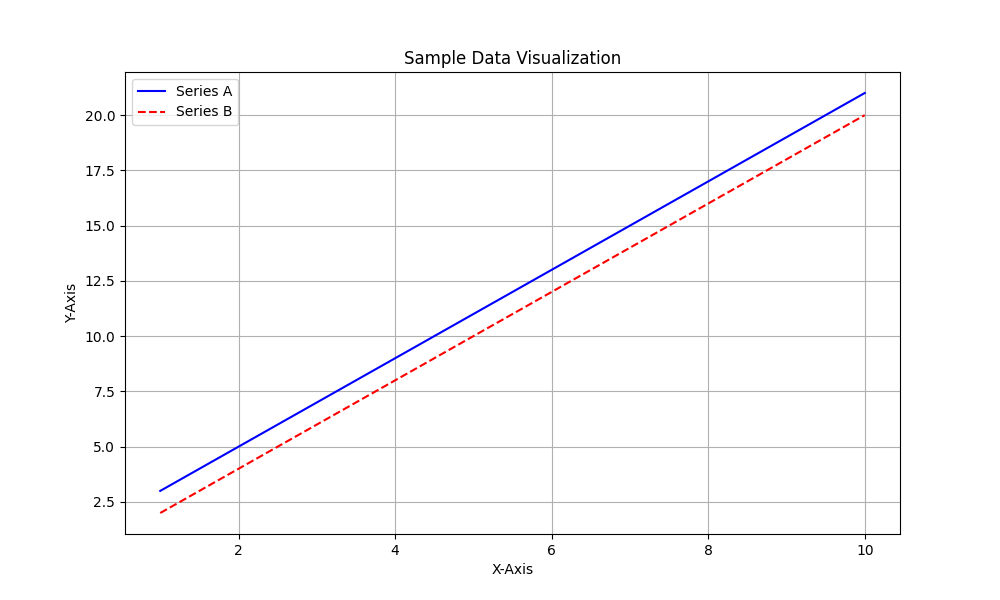


Sending image for analysis...



### Response:

The image shows a line graph titled "Sample Data Visualization".  The graph displays two series of data, labeled "Series A" and "Series B", plotted against an X-axis and a Y-axis.

* **Series A:** This series is represented by a solid blue line. It shows a generally linear positive relationship, meaning as the X-axis value increases, the Y-axis value also increases.  The line starts at approximately (1, 3) and ends at approximately (10, 21).

* **Series B:** This series is represented by a dashed red line.  It also shows a linear positive relationship, similar to Series A. The line starts at approximately (1, 2) and ends at approximately (10, 20).

* **Relationship between Series A and B:** Both series show a similar trend of increasing values along the X-axis. However, Series A consistently has higher Y-axis values than Series B for the same X-axis value. The difference between the two series appears relatively constant throughout the range of the graph.

* **Axes:** The X-axis ranges from approximately 1 to 10, and the Y-axis ranges from approximately 0 to 21.  The grid lines provide visual aids for estimating values.

In summary, the graph provides a simple visual comparison of two datasets, showing their linear growth and the consistent difference between them.  The data suggests a possible correlation between the X and Y variables for both series.  Without more context about what the X and Y axes represent, further interpretation is limited.


In [ ]:
# Function to create a sample test image
def create_test_plot():
    """Create a sample plot for testing image analysis."""
    plt.figure(figsize=(10, 6))

    # Create some sample data
    x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    y1 = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
    y2 = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

    # Plot the data
    plt.plot(x, y1, 'b-', label='Series A')
    plt.plot(x, y2, 'r--', label='Series B')

    # Add labels and title
    plt.xlabel('X-Axis')
    plt.ylabel('Y-Axis')
    plt.title('Sample Data Visualization')
    plt.legend()
    plt.grid(True)

    # Save the plot to a BytesIO object
    buf = BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)

    # Convert to PIL Image
    test_image = PILImage.open(buf)
    plt.close()

    return test_image

# Create a test image
test_image = create_test_plot()

# Display the image
display(Markdown("### Test Image:"))
display_image(test_image)

# Ask the chatbot to analyze the image
image_query = "What does this image show? Please analyze this chart in detail."

print("\nSending image for analysis...\n")
response = chatbot.send_message(image_query, test_image)
display(Markdown("### Response:"))
display(Markdown(response))

## Multimodal Prompting
### Combined Text and Image (Multimodal) Example
Now let's test the chatbot with a combined text and image input:

In [ ]:
# Create a multimodal prompt
multimodal_query = "Based on the trends shown in this chart, what might be a reasonable prediction for the next three data points in Series A? Explain your reasoning."

print("Sending multimodal query (text + image)...\n")
response = chatbot.send_message(multimodal_query, test_image)
display(Markdown("### Response:"))
display(Markdown(response))

Sending multimodal query (text + image)...



### Response:

Based on the linear trend exhibited by Series A, we can make a reasonable prediction for the next three data points.  The method used will be a simple linear extrapolation.  This is a crude method and assumes the linear trend continues perfectly, which may not be the case in real-world data.


**Reasoning:**

The graph shows a nearly perfectly linear relationship. To estimate the next points, we can visually approximate the slope of the line and extrapolate.  Alternatively, we can take two points from the graph and calculate the approximate slope. Let's use points (10, 21) and (4, 9) for this calculation.

* **Calculating the slope (m):**  m = (y2 - y1) / (x2 - x1) = (21 - 9) / (10 - 4) = 12 / 6 = 2

* **Finding the y-intercept (b):** Using the point-slope form of a linear equation (y - y1 = m(x - x1)), and the point (4, 9):

   9 - 9 = 2(x - 4)  This simplifies to 0 = 2(x - 4), which isn't helpful for getting 'b' because it doesn't have a proper y-intercept.  Let's use the point (10,21) instead.

   21 - 21 = 2(x-10) resulting in the same issue.  Let's use a different approach.  The line looks like it almost passes through the origin (0,0).  Therefore, we'll estimate the y-intercept as approximately 1.

* **Linear Equation:**  Using our estimated slope and y-intercept, the equation of the line is approximately y = 2x + 1

* **Prediction:** Now we can predict the next three data points (x = 11, 12, 13):

    * x = 11: y = 2(11) + 1 = 23
    * x = 12: y = 2(12) + 1 = 25
    * x = 13: y = 2(13) + 1 = 27


**Predicted Data Points for Series A:**

(11, 23), (12, 25), (13, 27)


**Important Caveat:** These predictions are based on a visual estimation and a simplified linear model.  Real-world data rarely follows perfect linear patterns.  More sophisticated techniques would be needed for a more accurate prediction, particularly if we had more data points or knew the underlying process generating the data.


## Advanced Feature: Response Streaming
Let's demonstrate how to stream responses from the model in real-time:

In [ ]:
display(Markdown("### Streaming Example"))
print("Sending query with streaming enabled...\n")

streaming_query = "Write a short paragraph explaining how neural networks learn from data."
print("Response (streaming):")
chatbot.send_message(streaming_query, stream=True)

### Streaming Example

Sending query with streaming enabled...

Response (streaming):
Neural networks learn through a process called training, where they adjust their internal parameters (weights and biases) to minimize the difference between their predictions and the actual values in a dataset.  This adjustment is guided by an algorithm, often backpropagation, which calculates the gradient of a loss function.  The loss function quantifies the error in the network's predictions.  The network iteratively updates its weights and biases in the direction that reduces this error, effectively learning patterns and relationships within the data.  This iterative process continues until the network's performance on a validation set plateaus or reaches a predefined level of accuracy.



"Neural networks learn through a process called training, where they adjust their internal parameters (weights and biases) to minimize the difference between their predictions and the actual values in a dataset.  This adjustment is guided by an algorithm, often backpropagation, which calculates the gradient of a loss function.  The loss function quantifies the error in the network's predictions.  The network iteratively updates its weights and biases in the direction that reduces this error, effectively learning patterns and relationships within the data.  This iterative process continues until the network's performance on a validation set plateaus or reaches a predefined level of accuracy.\n"

## Interactive function for user testing

### Input Image:

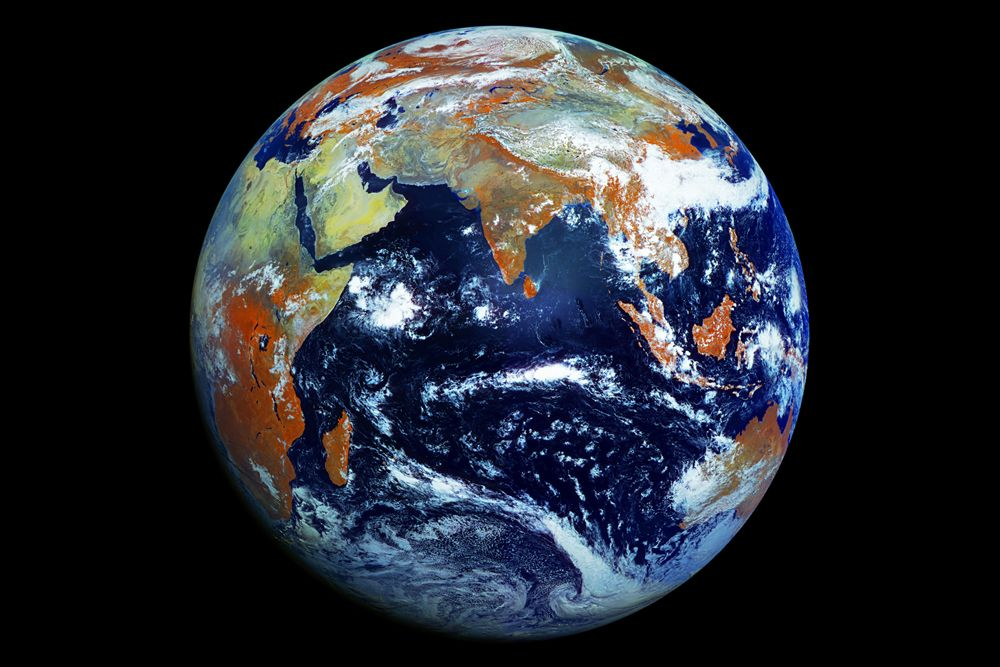

### Query: What's in this image?

### Response:

The image is a satellite photograph of planet Earth.  The view is from space, showing a nearly complete sphere of the planet against a black background.

The image shows a portion of the Indian Ocean, the Arabian Sea, the Bay of Bengal, and parts of Asia, Africa, and the southern Indian Ocean.  The landmasses are depicted in varying shades of brown, tan, and orange, reflecting different terrains and vegetation.  The oceans are primarily dark blue, with lighter blue swirls indicating cloud cover and ocean currents. There are visible white areas, which are likely clouds. The overall color palette is rich and detailed, suggesting a high-resolution image.  The contrast between the dark space background and the vibrant Earth makes the planet stand out prominently.


In [ ]:

def process_user_query(text_input=None, image_path=None):
    """
    Process a user query with optional image.

    Args:
        text_input: User's text query
        image_path: Path to an image file (optional)
    """
    image = None
    if image_path:
        image = load_image_from_path(image_path)
        if image:
            image = resize_image(image)
            display(Markdown("### Input Image:"))
            display_image(image)

    display(Markdown(f"### Query: {text_input}"))
    response = chatbot.send_message(text=text_input, image=image)
    display(Markdown("### Response:"))
    display(Markdown(response))

#example:
#process_user_query("What's in this image?", "/content/earth.jpg")
#uncomment to run
# format ( text , path to image)


## Customizing the ChatBot Parameters
You can adjust various parameters to change how the chatbot behaves:

In [ ]:

# Function to create a new chatbot with custom parameters
def create_custom_chatbot(
    temperature=0.7,
    max_tokens=2048,
    system_prompt="You are a helpful assistant that provides detailed, accurate information."
):
    """
    Create a new chatbot with custom parameters.

    Args:
        temperature: Controls randomness (0.0-1.0)
        max_tokens: Maximum response length
        system_prompt: Initial instructions

    Returns:
        Configured chatbot instance
    """
    return GeminiMultimodalChatBot(
        temperature=temperature,
        max_tokens=max_tokens,
        system_prompt=system_prompt
    )

# Example of creating a more creative chatbot
creative_bot = create_custom_chatbot(
    temperature=0.9,  # Higher temperature for more creative responses
    max_tokens=4096,
    system_prompt="You are a highly creative assistant. Provide imaginative, detailed responses that explore interesting possibilities."
)

# Example of creating a more precise, factual chatbot
precise_bot = create_custom_chatbot(
    temperature=0.1,  # Lower temperature for more deterministic responses
    max_tokens=2048,
    system_prompt="You are a precise, factual assistant. Provide concise, accurate information with minimal speculation."
)

## Error Handling and Rate Limiting
In production applications, you'll want robust error handling and rate limiting.

In [ ]:
def send_message_with_retry(
    chatbot: GeminiMultimodalChatBot,
    text: str = None,
    image: PILImage.Image = None,
    max_retries: int = 3,
    retry_delay: int = 2
):
    """
    Send a message with automatic retry for handling rate limits or transient errors.

    Args:
        chatbot: GeminiMultimodalChatBot instance
        text: Text prompt
        image: Image prompt (optional)
        max_retries: Maximum number of retry attempts
        retry_delay: Seconds to wait between retries

    Returns:
        Model response or error message
    """
    retries = 0

    while retries <= max_retries:
        try:
            response = chatbot.send_message(text=text, image=image)
            return response

        except Exception as e:
            error_message = str(e).lower()

            # Handle rate limiting
            if "rate limit" in error_message or "quota" in error_message:
                retries += 1
                if retries <= max_retries:
                    wait_time = retry_delay * retries
                    print(f"Rate limit reached. Retrying in {wait_time} seconds...")
                    time.sleep(wait_time)
                else:
                    return f"Error: Maximum retries reached due to rate limiting. Please try again later."

            # Handle other errors
            else:
                return f"Error communicating with Gemini API: {str(e)}"

    return "Failed to get response after multiple attempts."

## Conclusion and Next Steps

You've successfully built a multimodal chatbot using Google's Gemini API that can:
- Process text inputs
- Analyze images
- Handle combined text and image inputs
- Maintain conversation history
- Stream responses in real-time

Remember that responsible AI use is critical - ensure your chatbot adheres to ethical guidelines and respects user privacy.

### Useful API references:

[Text Generation](https://ai.google.dev/gemini-api/docs/text-generation?lang=python)

[Vision](https://ai.google.dev/gemini-api/docs/vision)

### Related examples

[Build a chat app with Gemini](https://ai.google.dev/gemini-api/tutorials/web-app?lang=python)

### Continue your discovery of the Gemini API

[Get Started with Gemini API](https://ai.google.dev/gemini-api/docs/quickstart?lang=python)
